In [64]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [65]:
# ## 2. Data Loading and Preprocessing
try:
    # 데이터 파일 로드
    train_df = pd.read_csv("/content/data/agr_en_train.csv", header=None, names=['source', 'text', 'label'])
    dev_df = pd.read_csv("/content/data/agr_en_dev.csv", header=None, names=['source', 'text', 'label'])

    # train과 dev 데이터를 합쳐서 전체 데이터셋으로 사용 후 다시 분할
    df = pd.concat([train_df, dev_df], ignore_index=True)

    print("Dataset loaded successfully.")
    print(f"Total dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'agr_en_train.csv' or 'agr_en_dev.csv' not found.")
    df = pd.DataFrame()

if not df.empty:
    # 텍스트 클리닝 함수
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text) # 알파벳과 공백만 남김
        text = re.sub(r'\s+', ' ', text).strip() # 여러 공백을 하나로
        return text

    df['cleaned_text'] = df['text'].apply(clean_text)

    # 레이블 인코딩
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    class_names = list(le.classes_)

    print("\nLabel mapping:", {i: label for i, label in enumerate(class_names)})


Dataset loaded successfully.
Total dataset shape: (15001, 3)

Label mapping: {0: 'CAG', 1: 'NAG', 2: 'OAG'}


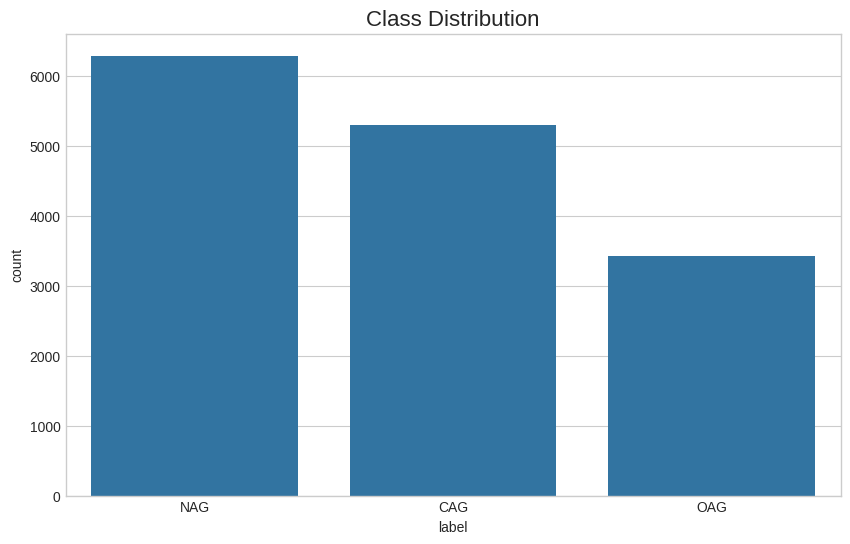

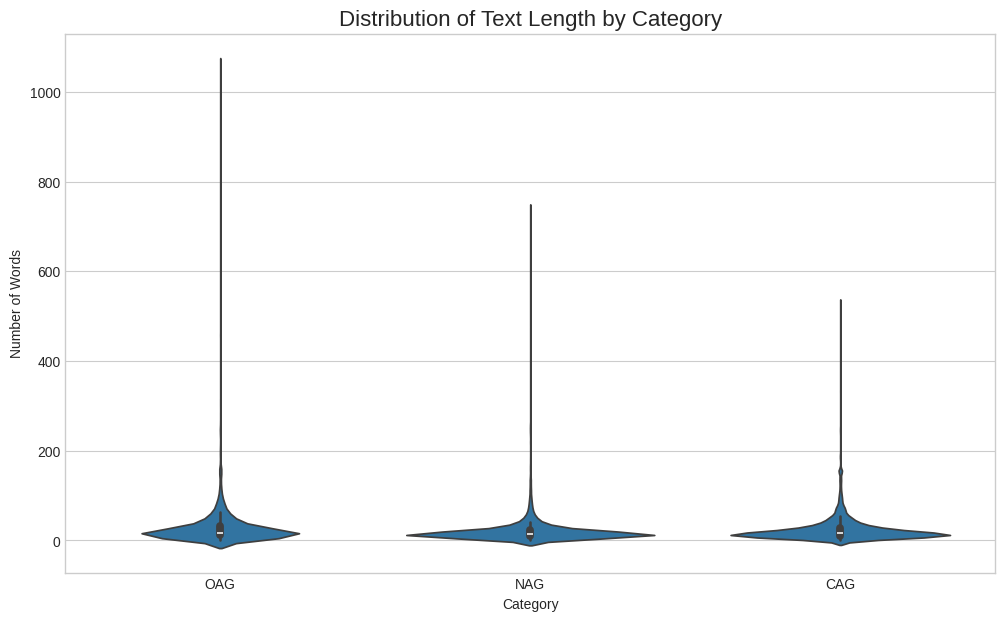

In [66]:
# ## 3. Exploratory Data Analysis (EDA)
if not df.empty:
    # 클래스 분포 확인
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
    plt.title('Class Distribution', fontsize=16)
    plt.show()

    # 텍스트 길이 분석
    df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(12, 7))
    sns.violinplot(x='label', y='text_length', data=df)
    plt.title('Distribution of Text Length by Category', fontsize=16)
    plt.xlabel('Category')
    plt.ylabel('Number of Words')
    plt.show()

In [67]:
# ## 4. Data Splitting
if not df.empty:
    X = df['cleaned_text']
    y = df['label_encoded']

    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


In [69]:
# ## 5. Model 1: LSTM (Deep Learning)
if not df.empty:
    print("\n--- Training Model 1: LSTM ---")

    # Keras Tokenizer & Padding
    VOCAB_SIZE = 10000
    MAX_LEN = 100
    EMBEDDING_DIM = 128

    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN, padding='post')
    X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, padding='post')

    # LSTM 모델 정의
    lstm_model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])

    lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = lstm_model.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.1,
        callbacks=[early_stopping]
    )

    # LSTM 모델 평가
    print("\n--- LSTM Evaluation ---")
    y_pred_lstm_probs = lstm_model.predict(X_test_pad)
    y_pred_lstm = np.argmax(y_pred_lstm_probs, axis=1)


--- Training Model 1: LSTM ---
Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.4019 - loss: 1.0767 - val_accuracy: 0.4475 - val_loss: 1.0608
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.4168 - loss: 1.0740 - val_accuracy: 0.4458 - val_loss: 1.0625
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 408ms/step - accuracy: 0.4148 - loss: 1.0704 - val_accuracy: 0.4442 - val_loss: 1.0591
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - accuracy: 0.4230 - loss: 1.0686 - val_accuracy: 0.4450 - val_loss: 1.0571
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.4258 - loss: 1.0637 - val_accuracy: 0.4458 - val_loss: 1.0600
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 370ms/step - accuracy: 0.4209 - loss: 1.0632 - val_accuracy: 0.4500 - val_loss: 1.0588
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 418ms/step - accuracy: 0.4309 - loss: 1.0580 - val_accuracy: 0.4492 - val_loss: 1.0575

--- LSTM Evaluation ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step


In [70]:
# ## 6. Model 2: LightGBM with TF-IDF (Machine Learning)
if not df.empty:
    print("\n--- Training Model 2: LightGBM with TF-IDF ---")

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=VOCAB_SIZE)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # LightGBM 모델 학습
    lgbm_model = LGBMClassifier(random_state=42)
    lgbm_model.fit(X_train_tfidf, y_train)

    # LightGBM 모델 평가
    print("\n--- LightGBM Evaluation ---")
    y_pred_lgbm = lgbm_model.predict(X_test_tfidf)
    print(f"LightGBM Test Accuracy: {accuracy_score(y_test, y_pred_lgbm)*100:.2f}%")



--- Training Model 2: LightGBM with TF-IDF ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48277
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 1499
[LightGBM] [Info] Start training from score -1.041051
[LightGBM] [Info] Start training from score -0.869884
[LightGBM] [Info] Start training from score -1.478775

--- LightGBM Evaluation ---
LightGBM Test Accuracy: 53.62%



================= 최종 결과 분석: LSTM =================


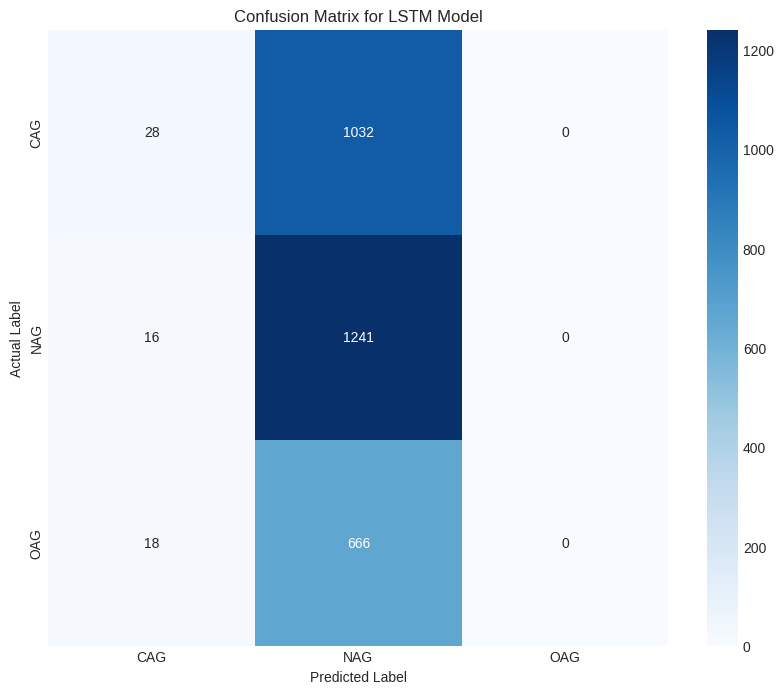


Classification Report for LSTM Model
              precision    recall  f1-score   support

         CAG       0.45      0.03      0.05      1060
         NAG       0.42      0.99      0.59      1257
         OAG       0.00      0.00      0.00       684

    accuracy                           0.42      3001
   macro avg       0.29      0.34      0.21      3001
weighted avg       0.34      0.42      0.27      3001


=============== 최종 결과 분석: LightGBM ===============


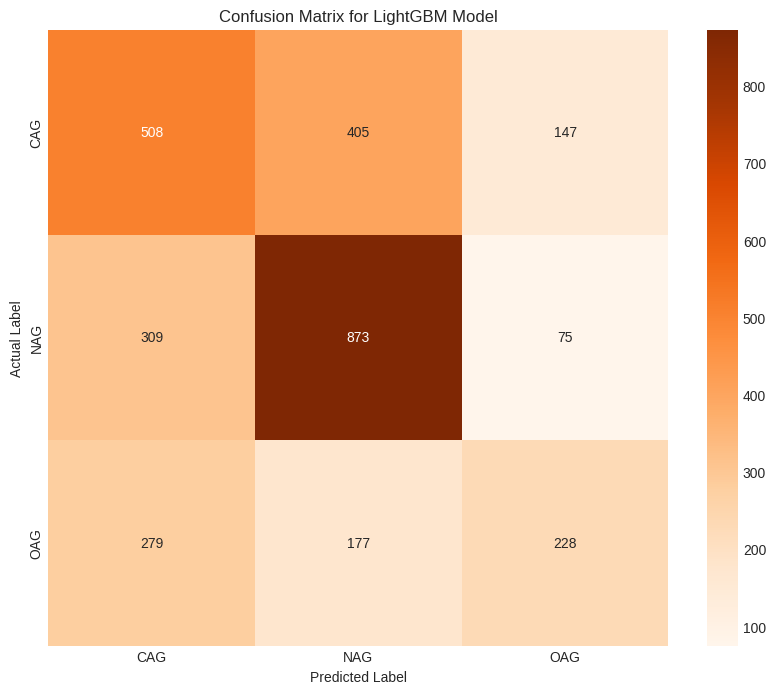


Classification Report for LightGBM Model
              precision    recall  f1-score   support

         CAG       0.46      0.48      0.47      1060
         NAG       0.60      0.69      0.64      1257
         OAG       0.51      0.33      0.40       684

    accuracy                           0.54      3001
   macro avg       0.52      0.50      0.51      3001
weighted avg       0.53      0.54      0.53      3001



In [71]:
# ## 7. Final Results Analysis
if not df.empty:
    print("\n" + "="*50)
    print(" 최종 결과 분석: LSTM ".center(50, "="))
    print("="*50)

    # LSTM 혼동 행렬
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for LSTM Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # LSTM 분류 리포트
    print('\nClassification Report for LSTM Model')
    print(classification_report(y_test, y_pred_lstm, target_names=class_names))

    print("\n" + "="*50)
    print(" 최종 결과 분석: LightGBM ".center(50, "="))
    print("="*50)

    # LightGBM 혼동 행렬
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for LightGBM Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # LightGBM 분류 리포트
    print('\nClassification Report for LightGBM Model')
    print(classification_report(y_test, y_pred_lgbm, target_names=class_names))